# IMDB 데이터 세트 - CNN + LSTM 모델
IMDB 데이터 세트를 합성곱 신경망과 장-단기 메모리 순환 신경망을 결합한 신경망으로 훈련 시킵니다.

문장으로 이루어진 IMDB 데이터를 받아와 문장이 긍정적인 평가라면 1을, 부정적인 평가라면 0을 출력하는 모델을 설계하고 훈련합니다.

In [0]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D

max_features = 20000  # 하이퍼 파라미터, 사용할 최대 특징 수
text_max_words = 200  # 하이퍼 파라미터, 사용할 최대 단어 수

## IMDB 데이터 세트 다운로드 및 가공
IMDB 데이터 세트를 다운로드 받은 뒤 훈련, 테스트, 검증 세트로 나눕니다.

새로운 버전의 numpy 와의 호환성 이슈를 해결하는 코드를 삽입 하였습니다.

* 훈련 세트는 20000를 사용합니다.
* 20000 index 이상의 데이터는 검증 세트로 사용합니다.
* 크기를 일정하게 하기 위해서 패딩을 추가합니다.

In [0]:
import numpy as np

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
np.load = np_load_old

x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

x_train = sequence.pad_sequences(x_train, maxlen=text_max_words)
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
x_test = sequence.pad_sequences(x_test, maxlen=text_max_words)

## 합성곱 장-단기 메모리 순환 신경망 구성
합성곱 장-단기 메모리 신경망과 임베딩 레이어에 기반한 신경망을 구성합니다.
* 첫번째 계층은 임베딩 레이어로, 순차화된 문장을 정규화 합니다.
* 정규화된 계층을 1차원 합성곱으로 특징을 추출 합니다.
* 가장 큰 값을 Pooling 하여 LSTM 레이어로 전달합니다.
* LSTM 레이어는 128개의 셀로 구성합니다.
* 마지막 계층은 이진분류를 위해 sigmoid 활성화 함수를 사용한 1개의 뉴런으로 구성합니다.

In [0]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=text_max_words))
model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

W0804 08:10:24.993166 139756417509248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



## 모델 정보 출력
* model.summary() 메소드를 이용하여 생성된 모델의 정보를 출력 합니다.
* Input, Output의 형태와 훈련 가능한 파라미터 개수를 출력 합니다.
* 훈련 가능한 파라미터 개수로 모델의 크기와 필요 자원을 예측해 볼 수 있습니다.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 198, 256)          98560     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,855,809
Trainable params: 2,855,809
Non-trainable params: 0
_________________________________________________________________


## 컴파일 및 훈련
* 이진 Corss Entropy 오류를 Adam Optimizer 를 이용하여 최소화 함을 정의합니다.
* 전체 데이터를 총 25번, 한 Backward pass 당 64개의 데이터 세트를 이용하여 훈련 함을 정의합니다.
* 컴파일 메소드를 이용하여 TensorFlow 그래프를 정의하여 훈련을 진행 합니다.

*Google Colab Cloud GPU를 이용하여 가속 하였습니다.*

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_val, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/25
20000/20000 [==============================] - 27s 1ms/step - loss: 0.3910 - acc: 0.8110 - val_loss: 0.3006 - val_acc: 0.8814
Epoch 2/25
20000/20000 [==============================] - 25s 1ms/step - loss: 0.1768 - acc: 0.9372 - val_loss: 0.3131 - val_acc: 0.8690
Epoch 3/25
20000/20000 [==============================] - 25s 1ms/step - loss: 0.0895 - acc: 0.9694 - val_loss: 0.4234 - val_acc: 0.8674
Epoch 4/25
20000/20000 [==============================] - 25s 1ms/step - loss: 0.0359 - acc: 0.9897 - val_loss: 0.4856 - val_acc: 0.8670
Epoch 5/25
20000/20000 [==============================] - 25s 1ms/step - loss: 0.0198 - acc: 0.9943 - val_loss: 0.5927 - val_acc: 0.8674
Epoch 6/25
20000/20000 [==============================] - 25s 1ms/step - loss: 0.0227 - acc: 0.9927 - val_loss: 0.5767 - val_acc: 0.8636
Epoch 7/25
20000/20000 [==============================] - 25s 1ms/step - loss: 0.0146 - acc: 0.9955 - val_loss: 0.6664 - val_acc:

## 시각화
matplotlib를 이용하여 훈련 경과를 출력합니다.

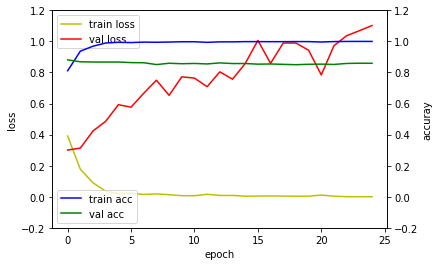

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 훈련 결과를 평가합니다.
손실과 신뢰도를 출력합니다.

In [0]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

25000/25000 [==============================] - 10s 414us/step
## evaluation loss and_metrics ##
[1.2400627689361572, 0.8422399999809265]
